# Customer Churn Project — Part 3: Logistic Regression Classifier (Baseline Model)

This notebook introduces the first predictive model for identifying high-risk users in our customer churn analysis pipeline. Building on earlier feature engineering, we train and evaluate a logistic regression model as an interpretable baseline for churn prediction.

In this notebook, I:
1. Assemble a behavioral feature matrix summarizing user engagement across sessions, songs, thumbs up/down, playlists, and activity duration.
2. Train a logistic regression model to predict churn using PySpark’s MLlib.
3. Evaluate performance using ROC-AUC and interpret key feature coefficients.
4. Simulate a retention scenario: boosting user activity to test its impact on churn probability.
5. Identify users most likely to benefit from engagement-based interventions.

This model serves as a benchmark and provides early business insights into which behaviors most strongly influence user retention. More complex classifiers (e.g., Random Forest, XGBoost) are explored in the subsequent notebook: [04_Random_Forest_&_XGBoost.ipynb](04_Random_Forest_&_XGBoost.ipynb).

In [1]:
import json
import pandas as pd
import numpy as np
import os
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import cm
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import roc_curve, auc



sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [2]:
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home"

try:
    spark.stop()
except:
    pass


spark = (
    SparkSession.builder
    .appName("CustomerChurn_EDA")
    .master("local[*]")
    .config("spark.driver.memory", "6g")  
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")
#print("✅ Spark started:", spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/16 13:30:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data = spark.read.parquet("../data/churn_data_ready.parquet")

In [4]:
user_features = (
    data.groupBy("userId")
    .agg(
        F.first("churn_flag").alias("churn_flag"),
        F.countDistinct("sessionId").alias("num_sessions"),
        F.sum(F.when(F.col("page") == "NextSong", 1).otherwise(0)).alias("num_songs"),
        F.sum(F.when(F.col("page") == "Thumbs Up", 1).otherwise(0)).alias("thumbs_up"),
        F.sum(F.when(F.col("page") == "Thumbs Down", 1).otherwise(0)).alias("thumbs_down"),
        F.sum(F.when(F.col("page") == "Add to Playlist", 1).otherwise(0)).alias("add_playlist"),
        ( (F.max("ts") - F.min("ts")) / (1000 * 60 * 60 * 24) ).alias("active_days")
    )
)

In [5]:
user_features.head(10)

[Row(userId='1567623', churn_flag=0, num_sessions=16, num_songs=1135, thumbs_up=65, thumbs_down=15, add_playlist=39, active_days=55.644050925925924),
 Row(userId='1396135', churn_flag=0, num_sessions=9, num_songs=974, thumbs_up=49, thumbs_down=9, add_playlist=21, active_days=52.782233796296296),
 Row(userId='1444744', churn_flag=1, num_sessions=21, num_songs=1406, thumbs_up=63, thumbs_down=15, add_playlist=53, active_days=57.14454861111111),
 Row(userId='1082354', churn_flag=0, num_sessions=13, num_songs=442, thumbs_up=19, thumbs_down=7, add_playlist=10, active_days=53.66190972222222),
 Row(userId='1633767', churn_flag=0, num_sessions=29, num_songs=2853, thumbs_up=138, thumbs_down=29, add_playlist=88, active_days=50.004502314814815),
 Row(userId='1187490', churn_flag=0, num_sessions=21, num_songs=1963, thumbs_up=95, thumbs_down=22, add_playlist=62, active_days=58.980358796296294),
 Row(userId='1180483', churn_flag=0, num_sessions=6, num_songs=168, thumbs_up=13, thumbs_down=1, add_playl

In [6]:
user_features.count()

22261

### I. Baseline Logistic Model

In [7]:
feature_cols = ["num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]

In [8]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
lr = LogisticRegression(labelCol="churn_flag", featuresCol="features")
pipeline = Pipeline(stages=[assembler, lr])

train_df, test_df = user_features.randomSplit([0.7, 0.3], seed=42)

lr_model = pipeline.fit(train_df)

predictions = lr_model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="churn_flag", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC-AUC (Baseline Logistic Regression): {roc_auc:.3f}")

ROC-AUC (Baseline Logistic Regression): 0.855


AUC-ROC (Area Under the Receiver Operating Characteristic Curve) shows how well the model can distinguish between churned and active users. The ROC-AUC = 0.855 means the model performs very well, it can correctly rank most users by their churn risk. 


So, for example, if we randomly select one churned user and one active user, there’s an ~85% chance the model will assign a higher churn probability to the churned user. This means features like num_sessions, thumbs_up, active_days, etc., are already quite informative — even without advanced models.

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_25570/572184597.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # or "seismic", "bwr", etc.


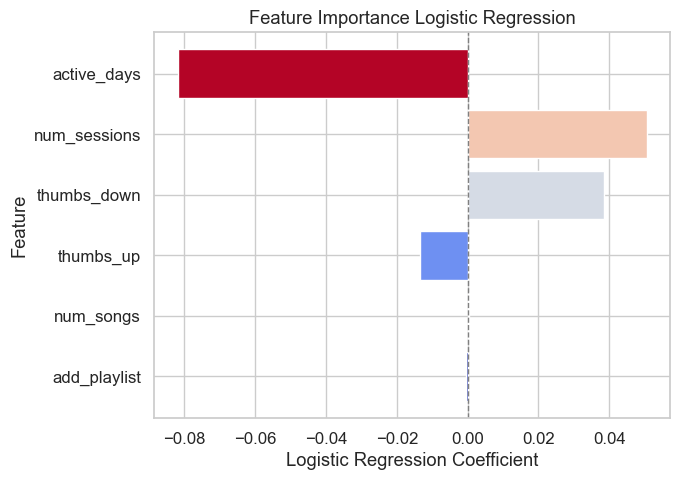

In [9]:
coefficients = lr_model.stages[-1].coefficients
intercept = lr_model.stages[-1].intercept
coef_df = pd.DataFrame({"feature": feature_cols, "coefficient": coefficients})

sorted_coef_df = coef_df.sort_values("coefficient", key=abs, ascending=True).reset_index(drop=True)

norm = plt.Normalize(abs(sorted_coef_df['coefficient']).min(), abs(sorted_coef_df['coefficient']).max())
cmap = cm.get_cmap("coolwarm")  # or "seismic", "bwr", etc.
colors = [cmap(norm(abs(c))) for c in sorted_coef_df['coefficient']]

plt.figure(figsize=(7, 5))
plt.barh(sorted_coef_df['feature'], sorted_coef_df['coefficient'], color=colors)
plt.xlabel("Logistic Regression Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance Logistic Regression")
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

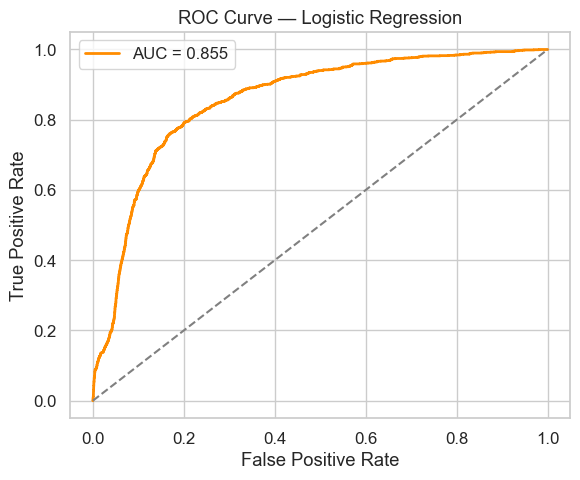

In [10]:
pdf = predictions.select("userId", "churn_flag", "probability").toPandas()
pdf["prob_churn"] = pdf["probability"].apply(lambda x: float(x[1]))

fpr, tpr, _ = roc_curve(pdf["churn_flag"], pdf["prob_churn"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

Together, the AUC score and the model coefficients suggest that the logistic regression model is highly effective at identifying churners based on a small set of behavioral features. The model doesn’t just rely on how much users engage, but rather on the quality of that engagement. For example, users who give more thumbs up or have more active days are less likely to churn, indicating that positive interaction and frequent activity are strong signals of retention. 

On the other hand, features like thumbs down are clear indicators of dissatisfaction and are positively associated with churn. Interestingly, even though features like the total number of songs played or sessions completed might suggest higher engagement, they don’t necessarily reduce churn and in some cases may slightly increase it — possibly capturing “last attempts” before a user leaves. Overall, these behavioral signals can be used to predict churn early and guide proactive interventions to improve user retention.

### II. Confusion Matrix

True Negatives (TN): 4586 — Correctly predicted 'Not Churn'
False Positives (FP): 401 — Type I Error (Predicted 'Churn' but actually 'Not Churn')
False Negatives (FN): 734 — Type II Error (Predicted 'Not Churn' but actually 'Churn')
True Positives (TP): 752 — Correctly predicted 'Churn'


<Figure size 500x400 with 0 Axes>

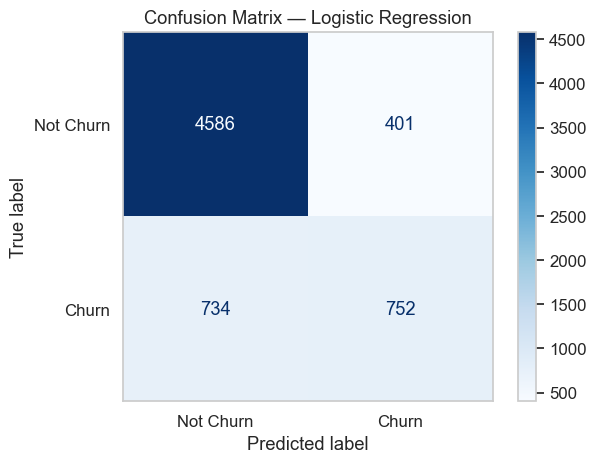

In [11]:
pdf["predicted"] = (pdf["prob_churn"] >= 0.5).astype(int)
cm = confusion_matrix(pdf["churn_flag"], pdf["predicted"])
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives (TN): {tn} — Correctly predicted 'Not Churn'")
print(f"False Positives (FP): {fp} — Type I Error (Predicted 'Churn' but actually 'Not Churn')")
print(f"False Negatives (FN): {fn} — Type II Error (Predicted 'Not Churn' but actually 'Churn')")
print(f"True Positives (TP): {tp} — Correctly predicted 'Churn'")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Churn", "Churn"])
plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Logistic Regression")
plt.grid(False)
plt.show()

Overall, the model correctly identifying a large number of users who stayed (True Negative = 4586) and users who churned (True Positive = 752). These cases are straightforward — the former require no action, and the latter represent users the model correctly flagged for potential retention strategies.

However, two types of misclassification require closer attention:

* False Positives (401 users) occur when the model predicts churn, but the user actually remains active. This is a Type I error. While it might lead to unnecessary retention offers or outreach, the cost is relatively minor since the user ultimately stays, and such actions could even strengthen their loyalty.

* False Negatives (734 users) are more concerning. In these cases — Type II errors — the model predicts the user will stay, but they churn instead. These missed churners represent a direct loss in revenue and missed opportunities to intervene. From a business perspective, this is the most expensive error type, especially if these users have high customer lifetime value (CLV).

### III. Churn Risk Scoring

Merging predicted data with the original dataset.


In [12]:
user_features_clean = user_features.drop("churn_flag")  # in Spark
user_features_pdf = user_features_clean.toPandas()
pdf = pdf.merge(user_features_pdf, on="userId", how="left")
pdf

,userId,churn_flag,probability,prob_churn,predicted,num_sessions,num_songs,thumbs_up,thumbs_down,add_playlist,active_days
0,1000214,0,"[0.8917483617215857, 0.10825163827841433]",0.108252,0,27,2005,101,25,64,58.426806
1,1000353,1,"[0.6496881041810953, 0.35031189581890465]",0.350312,0,4,239,13,4,4,21.933322
2,1000662,0,"[0.9586365949189707, 0.041363405081029314]",0.041363,0,15,899,87,7,31,52.006863
3,1000908,0,"[0.2755631428186788, 0.7244368571813212]",0.724437,1,1,24,2,1,1,0.067361
4,1001607,0,"[0.9321081351054474, 0.06789186489455257]",0.067892,0,20,1929,107,16,51,54.774479
...,...,...,...,...,...,...,...,...,...,...,...
6468,1997746,0,"[0.8801414431027844, 0.11985855689721558]",0.119859,0,12,655,36,21,25,49.912373
6469,1998434,0,"[0.43280675305817834, 0.5671932469418217]",0.567193,1,2,167,8,3,5,9.842419
6470,1999120,0,"[0.9267482011289283, 0.0732517988710717]",0.073252,0,4,56,5,0,5,43.872049
6471,1999892,1,"[0.477693499250673, 0.522306500749327]",0.522307,1,11,315,13,11,11,21.285961


In [13]:
# top 10 users most at risk of churning 
display_cols = ["userId", "churn_flag", "prob_churn", "num_sessions", "num_songs", "thumbs_up", "thumbs_down", "add_playlist", "active_days"]
top_churn_risk = pdf.sort_values("prob_churn", ascending=False).head(10)

cols_in_pdf = [col for col in display_cols if col in top_churn_risk.columns]
missing_cols = [col for col in display_cols if col not in top_churn_risk.columns]

print("Top 10 users at risk of churn (highest predicted probabilities):")
if cols_in_pdf:
    display(top_churn_risk[cols_in_pdf].style.format({"prob_churn": "{:.3f}"}).background_gradient(subset=["prob_churn"], cmap="Reds"))
else:
    print(top_churn_risk)

Top 10 users at risk of churn (highest predicted probabilities):


,userId,churn_flag,prob_churn,num_sessions,num_songs,thumbs_up,thumbs_down,add_playlist,active_days
892,1561239,0,0.995,93,5035,255,154,153,60.056574
1422,1884384,1,0.974,92,6249,295,63,181,35.519988
5049,1116029,1,0.962,123,7514,383,74,221,56.465799
4866,1988412,0,0.947,84,3843,209,102,118,60.204132
5050,1117871,1,0.937,40,2369,131,73,62,27.334502
1199,1748906,1,0.929,74,5127,245,60,150,38.479769
5056,1120634,1,0.924,43,2773,127,78,72,36.631725
1159,1730425,1,0.923,82,7692,379,75,212,42.321910
805,1512450,1,0.921,36,1958,88,66,62,29.439387
2584,1600492,1,0.910,37,1879,83,58,65,28.524086


The table above highlights the top 10 users with the highest predicted risk of churn, based on their behavioral patterns. All of these users have a predicted churn probability above 0.91, indicating a high level of confidence from the model. 

Interestingly, 8 out of 10 users in this list actually churned (churn_flag = 1), confirming that the model is correctly identifying high-risk individuals. Two users (user 892 and 5049) were predicted to have very high churn risk (0.995) but did not churn. This represents a False Positive, as described above, which—while not ideal—is less costly than missing an actual churner.


### IV. Simple Retention Simulation

In this section, I simulate how a small behavioral change (adding five more active days) affects churn probability for high-risk users. Even though I am using a baseline logistic regression model, it outputs probabilities, which allows us to run meaningful “what-if” scenarios.

I focus on users with a predicted churn probability above 0.8 and simulate what happens if they become more engaged. After updating their active_days feature and re-running predictions, I compare the new probabilities to the original ones.

In [14]:
high_risk_users = pdf[pdf["prob_churn"] > 0.8].copy() # threshold is 0.8
high_risk_users["original_prob"] = high_risk_users["prob_churn"]

high_risk_users["active_days"] += 5

X_sim = high_risk_users[["userId"] + feature_cols]

X_sim_spark = spark.createDataFrame(X_sim)
simulated_preds = lr_model.transform(X_sim_spark).select("userId", "probability").toPandas()

simulated_preds["new_prob"] = simulated_preds["probability"].apply(lambda x: float(x[1]))
simulated_preds = simulated_preds[["userId", "new_prob"]]

high_risk_users = high_risk_users.merge(simulated_preds, on="userId", how="left")
high_risk_users["probability_drop"] = high_risk_users["original_prob"] - high_risk_users["new_prob"]

cols_to_fix = ["original_prob", "new_prob", "probability_drop"]
for col in cols_to_fix:
    high_risk_users[col] = pd.to_numeric(high_risk_users[col], errors="coerce")

result = high_risk_users.dropna(subset=cols_to_fix)[["userId"] + cols_to_fix]
result = high_risk_users.dropna(subset=cols_to_fix)[["userId", "original_prob", "new_prob", "probability_drop"]] \
         .sort_values("probability_drop", ascending=False)

display(
    result.style
    .format({col: "{:.3f}" for col in cols_to_fix})
    .background_gradient(cmap="RdYlGn_r", subset=["probability_drop"])
)

,userId,original_prob,new_prob,probability_drop
26,1398238,0.802,0.729,0.073
15,1072640,0.803,0.730,0.073
9,1732870,0.808,0.736,0.072
4,1535488,0.813,0.742,0.070
22,1964551,0.813,0.743,0.070
37,1953266,0.826,0.759,0.067
12,1870948,0.828,0.761,0.066
23,1121796,0.831,0.765,0.066
25,1275576,0.831,0.765,0.066
28,1920391,0.835,0.771,0.064


25/10/16 04:33:31 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:131)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:700)
	at org.apache.spark.storage.BlockManagerMasterE

As we can see, model responds strongly to active_days. A simple increase of five active days led to a churn probability drop of 5–7 percentage points for many high-risk users. Even users with an original churn risk above 0.85 became less likely to leave.

This suggests that consistent activity is a powerful retention signal. More importantly, it shows that high-risk users aren’t a lost cause — they’re still responsive. A small behavioral shift can make a measurable difference.

From a business standpoint, this supports low-cost interventions like nudges, re-engagement emails, or personalized content. The model doesn’t just predict churn — it points to actions that can help prevent it.

### Summary:

In this notebook, I built a baseline churn prediction model using logistic regression. The model was trained on user engagement features and achieved a solid ROC-AUC of ~0.855, indicating strong separability between churned and retained users.

Beyond classification, I explored actionable simulations by increasing active_days for high-risk users, demonstrating that engagement can significantly reduce churn probability for certain segments. This analysis helps translate model insights into practical retention strategies.

**Why I Used Logistic Regression First?**

* Speed & Simplicity: It trains quickly and is easy to interpret, making it ideal for initial modeling stages.
* Probabilistic Output: Instead of just classifying churn/no churn, it provides churn risk scores, which are valuable for ranking users and targeting interventions.
* Baseline Performance: It sets a clear, explainable baseline—helping us measure how much lift we gain from more advanced models later.
* Low Overfitting Risk: On small to mid-sized datasets (like my dataset with ~20,000 users), it typically performs reliably without overfitting.

But while logistic regression is a strong starting point, **it comes with important constraints:**

* It creates linear decision boundaries, which means it may miss complex, nonlinear relationships between features.
* It assumes feature independence, which isn’t always true in behavioral data like user activity logs.
* It doesn’t capture interactions between features unless you manually engineer them.
* And while it offers coefficients for interpretation, it lacks richer tools like tree-based feature importance or SHAP values for deeper explainability.

These trade-offs are why more powerful models will be explored in the next stages.


### Next Steps:

With a strong baseline established, the next phase will focus on building more flexible and powerful models to improve prediction and uncover deeper behavioral patterns.Here’s what I’ll do next:

* Test advanced classifiers like XGBoost, Random Forest, and Regularized Logistic Regression.
* Compare model performance using metrics like AUC and precision-recall.
* Analyze feature importance and explainability with SHAP values.
* Simulate user behavior changes to see how predictions respond.
* Evaluate robustness to noise and missing data.

The goal is to move beyond prediction into understanding — and designing smarter, data-driven retention strategies. Please find my next notebook: [04_Random_Forest_&_XGBoost.ipynb](04_Random_Forest_&_XGBoost.ipynb)